<a href="https://colab.research.google.com/github/larissavaladao/py6s_harmonize_sample/blob/main/6.%20parameters_by_period/area_spm_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import geopandas as gpd
import pandas as pd
import math
import ee
import geemap

In [2]:
ee.Authenticate()
ee.Initialize(project='ee-curuai2')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import image collections

In [19]:
monthly_mosaics =  ee.ImageCollection('projects/ee-curuai2/assets/landsat_water_period/water_period')
display(monthly_mosaics.limit(2).getInfo())

{'type': 'ImageCollection',
 'bands': [],
 'version': 1740749237917506,
 'id': 'projects/ee-curuai2/assets/landsat_water_period/water_period',
 'features': [{'type': 'Image',
   'bands': [{'id': 'blue_mean',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'dimensions': [4254, 2108],
     'crs': 'EPSG:32621',
     'crs_transform': [30, 0, 598650, 0, -30, -211470]},
    {'id': 'green_mean',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'dimensions': [4254, 2108],
     'crs': 'EPSG:32621',
     'crs_transform': [30, 0, 598650, 0, -30, -211470]},
    {'id': 'red_mean',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'dimensions': [4254, 2108],
     'crs': 'EPSG:32621',
     'crs_transform': [30, 0, 598650, 0, -30, -211470]},
    {'id': 'nir_mean',
     'data_type': {'type': 'PixelType', 'precision': 'double'},
     'dimensions': [4254, 2108],
     'crs': 'EPSG:32621',
     'crs_transform': [30, 0, 598650, 0, -30, -211470]},
 

## Get mean SPM value per image

In [20]:
def spm_stat_calc(img):
  '''receives a masked SPM classified image of curuai and returns mean SPM within the floodplain limits
  as a property of the input image'''


  floodplain = ee.FeatureCollection('projects/ee-curuai2/assets/varzea_alagavel')


  stats = img.select("classification").reduceRegion(**{
    'reducer': ee.Reducer.mean().combine(
    reducer2=ee.Reducer.stdDev(), sharedInputs=True).combine(
    reducer2=ee.Reducer.max(), sharedInputs=True).combine(
    reducer2=ee.Reducer.min(), sharedInputs=True),
    'geometry': floodplain.geometry(),
    'scale': 30,
    'maxPixels': 1e10
    })

  return img.set({'mean_SPM':stats.get('classification_mean'),
                  'max_SPM':stats.get('classification_max'),
                  'min_SPM':stats.get('classification_min'),
                  'stdDev_SPM':stats.get('classification_stdDev')})

In [21]:
spm_classified_stat = monthly_mosaics.map(spm_stat_calc)
display(spm_classified_stat.size().getInfo())

3

#transform to dataframe

In [22]:
dfArea = ee.data.computeFeatures({
    'expression': ee.FeatureCollection(spm_classified_stat.map(lambda img: ee.Feature(None,img.toDictionary()))),
    'fileFormat': 'PANDAS_DATAFRAME'
})
dfArea

,geo,area_km2,band_count,max_SPM,mean_SPM,min_SPM,month_end,month_init,stdDev_SPM,timestamp,year
0,None,989.084758,6,306.049042,73.535345,6.644032,3,1,51.890127,2000-01-01,2000
1,None,1120.081590,6,282.490112,23.548032,5.342866,6,4,23.030719,2000-04-01,2000
2,None,1335.446135,6,282.490112,22.679618,5.844900,9,7,15.929416,2000-07-01,2000


In [23]:
def return_period(month):
  if month == 1:
    return 'R'
  elif month == 4:
    return 'HW'
  elif month == 7:
    return 'F'
  elif month == 10:
    return 'LW'
  else:
    return 'U'

In [24]:
dfArea = dfArea[['area_km2','mean_SPM','max_SPM','min_SPM','stdDev_SPM',	'month_end',	'month_init',	'timestamp',	'year',]].copy()
dfArea['WATER_PERIOD'] = dfArea.apply(lambda row: return_period(row['month_init']),axis = 1)
dfArea

,area_km2,mean_SPM,max_SPM,min_SPM,stdDev_SPM,month_end,month_init,timestamp,year,WATER_PERIOD
0,989.084758,73.535345,306.049042,6.644032,51.890127,3,1,2000-01-01,2000,R
1,1120.081590,23.548032,282.490112,5.342866,23.030719,6,4,2000-04-01,2000,HW
2,1335.446135,22.679618,282.490112,5.844900,15.929416,9,7,2000-07-01,2000,F


#view timne series

## area

<Axes: xlabel='timestamp', ylabel='area_km2'>

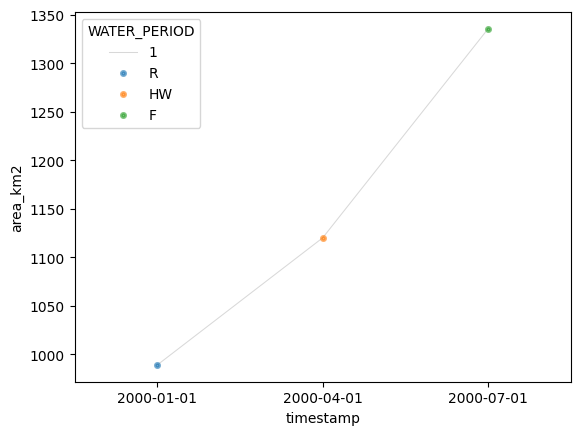

In [25]:
import seaborn as sns
sns.lineplot(data=dfArea, x ='timestamp',y= 'area_km2',  alpha=.3,color='gray',size=1)
sns.pointplot(data=dfArea, x ='timestamp',y= 'area_km2',markersize=3,linestyle='none',  alpha=.6,hue='WATER_PERIOD',native_scale=False)

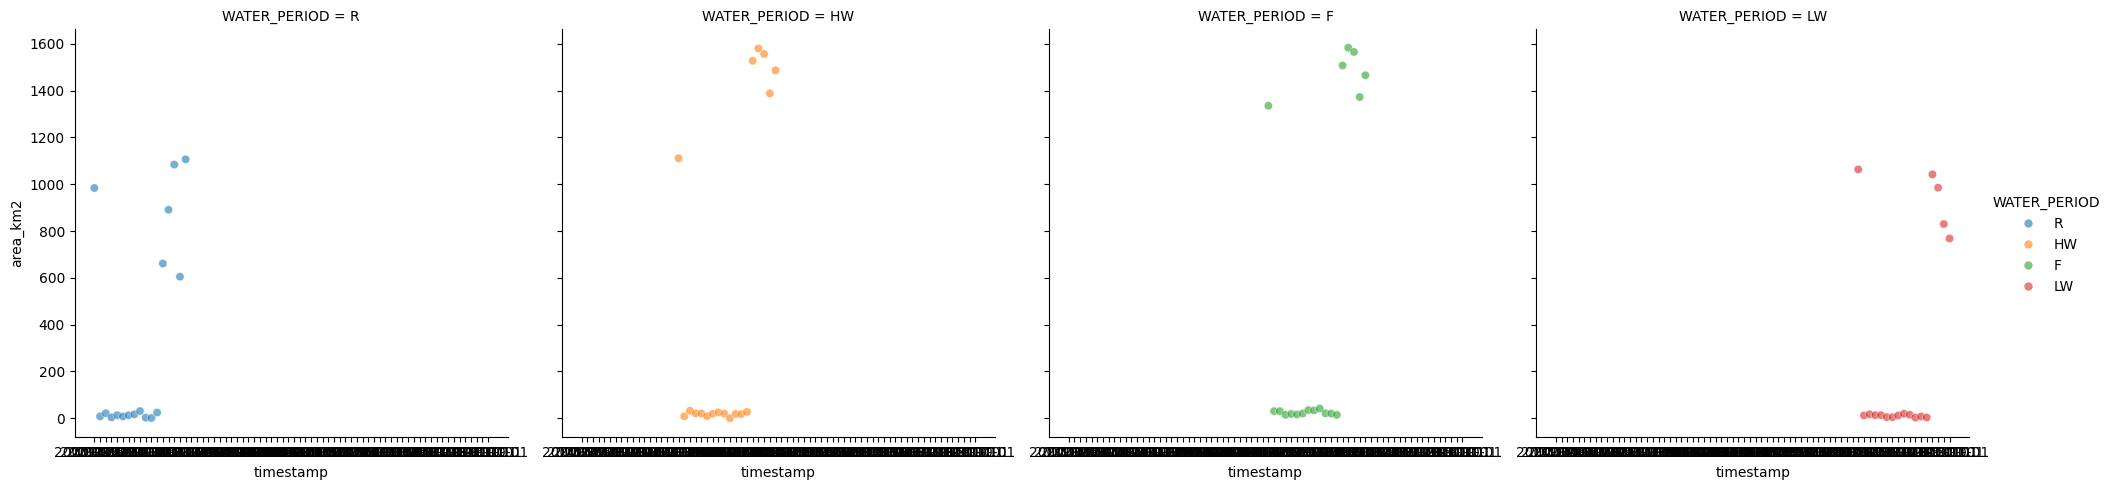

In [ ]:

sns.relplot(data=dfArea, x ='timestamp',y= 'area_km2',  alpha=.6,hue='WATER_PERIOD',col='WATER_PERIOD')

## SPM

##Export results

In [ ]:
#export table results
dfArea.to_csv('/content/drive/MyDrive/CURUAI_PROCESS/area_SPM_time_series.csv')